In [ ]:
import os
import sqlalchemy
import yaml
import pandas as pd
from pandas.io.sql import read_sql_table
from sqlalchemy import create_engine, inspect
import psycopg2
from psycopg2 import sql

class RdsDatabaseConnecter:
    '''
     A class to connect to an RDS Database and perform various operations
    '''
    def __init__(self, credentials_file):
        '''
        Initialize a connection to the RDS Database with a credentials file
        '''
        self.credentials_dict = self.read_credentials(credentials_file)
        self.engine = self.get_connection()

    def read_credentials(self, file):
        '''
        Reads the credentials file from a given file
        '''
        with open(file, mode="r") as file:
            credentials_dict = yaml.safe_load(file)
        return credentials_dict

    def get_connection(self):
        '''
        Get a connection the the RDS Database using the credentials

        '''
        return create_engine(
            f"postgresql+psycopg2://{self.credentials_dict['RDS_USER']}:{self.credentials_dict['RDS_PASSWORD']}@{self.credentials_dict['RDS_HOST']}:{self.credentials_dict['RDS_PORT']}/{self.credentials_dict['RDS_DATABASE']}")

    def get_table_names(self):
        '''
        Get all the names of the tables in the RDS Database
        '''
        inspector = inspect(self.engine)
        return inspector.get_table_names()

    def extract_data(self, table_name):
        '''
         Extract the data from the given table in the RDS Database
        '''
        conn = psycopg2.connect(dbname=self.credentials_dict['RDS_DATABASE'], user=self.credentials_dict['RDS_USER'], password=self.credentials_dict['RDS_PASSWORD'], host=self.credentials_dict['RDS_HOST'], port=self.credentials_dict['RDS_PORT'])
        cur = conn.cursor()
        query = sql.SQL("SELECT * FROM {}").format(sql.Identifier(table_name))
        cur.execute(query)
        rows = cur.fetchall()
        df = pd.DataFrame(rows, columns=[desc[0] for desc in cur.description])
        conn.close()
        return df

    def save_data_to_csv(self, df, filename):
        '''
         Save the given DataFrame to a CSV file with the given filename
        '''
        if not filename.endswith('.csv'):
            filename += '.csv'
        df.to_csv(filename, index=False)
        print(f"Data saved to {os.path.abspath(filename)}")

if __name__ == '__main__':
    '''
    Main function to execute the script with error handling
    '''
    try:
        rds = RdsDatabaseConnecter('credentials.yaml')
        print(f"Connection to the {rds.credentials_dict['RDS_HOST']} for user {rds.credentials_dict['RDS_USER']} created successfully.")
        df = rds.extract_data('loan_payments')
        print("Data from table 'loan_payments':")
        rds.save_data_to_csv(df, 'loan_payments.csv')
    except Exception as ex:
        print("An error occurred: \n", ex)

Connection to the eda-projects.cq2e8zno855e.eu-west-1.rds.amazonaws.com for user loansanalyst created successfully.
Data from table 'loan_payments':
Data saved to /content/loan_payments.csv


In [ ]:
import datetime as dt
import os
import pandas as pd


def read_csv_file():
    data_set = pd.read_csv('loan_payments.csv')
    return data_set

df = read_csv_file()
df.head()

,id,member_id,loan_amount,funded_amount,funded_amount_inv,term,int_rate,instalment,grade,sub_grade,...,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type
0,38676116,41461848,8000,8000.0,8000.0,36 months,7.49,248.82,A,A4,...,0.0,0.0,Jan-2022,248.82,Feb-2022,Jan-2022,0.0,5.0,1,INDIVIDUAL
1,38656203,41440010,13200,13200.0,13200.0,36 months,6.99,407.52,A,A3,...,0.0,0.0,Jan-2022,407.52,Feb-2022,Jan-2022,0.0,NaN,1,INDIVIDUAL
2,38656154,41439961,16000,16000.0,16000.0,36 months,7.49,497.63,A,A4,...,0.0,0.0,Oct-2021,12850.16,NaN,Oct-2021,0.0,NaN,1,INDIVIDUAL
3,38656128,41439934,15000,15000.0,15000.0,36 months,14.31,514.93,C,C4,...,0.0,0.0,Jun-2021,13899.67,NaN,Jun-2021,0.0,NaN,1,INDIVIDUAL
4,38656121,41439927,15000,15000.0,15000.0,36 months,6.03,456.54,A,A1,...,0.0,0.0,Jan-2022,456.54,Feb-2022,Jan-2022,0.0,NaN,1,INDIVIDUAL


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54231 entries, 0 to 54230
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           54231 non-null  int64  
 1   member_id                    54231 non-null  int64  
 2   loan_amount                  54231 non-null  int64  
 3   funded_amount                51224 non-null  float64
 4   funded_amount_inv            54231 non-null  float64
 5   term                         49459 non-null  object 
 6   int_rate                     49062 non-null  float64
 7   instalment                   54231 non-null  float64
 8   grade                        54231 non-null  object 
 9   sub_grade                    54231 non-null  object 
 10  employment_length            52113 non-null  object 
 11  home_ownership               54231 non-null  object 
 12  annual_inc                   54231 non-null  float64
 13  verification_sta

In [ ]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
from scipy.special import boxcox1p
from scipy.stats import zscore

class DataTransform:
    def __init__(self, df):
        self.df = df

    def transform_dtypes(self):
        # Convert 'term' to int64
        self.df['term'] = self.df['term'].astype(str).str.strip().str.replace(' months', '')
        self.df['term'] = pd.to_numeric(self.df['term'], errors='coerce').fillna(0).astype('int64')

        # Convert 'employment_length' to int64
        self.df['employment_length'] = self.df['employment_length'].astype(str).replace('nan', '0').apply(self.convert_emp_length).fillna(0).astype('int64')

        # Convert 'issue_date', 'earliest_credit_line', 'last_payment_date', 'next_payment_date', 'last_credit_pull_date' to datetime64
        for column in ['issue_date', 'earliest_credit_line', 'last_payment_date', 'next_payment_date' , 'last_credit_pull_date']:
            self.df[column] = pd.to_datetime(self.df[column], errors='coerce')

    def preprocess_date(date_str):
       # Add your preprocessing logic here
       # For example, if your dates are in the format 'dd-mm-yyyy' or 'dd/mm/yyyy', you can do:
        date_str = date_str.replace('-', '/')

       # Then, try to convert the preprocessed string to a date
        try:
            return pd.to_datetime(date_str, format='%d/%m/%Y')
        except ValueError:
        # If the conversion fails, return the original string
            return date_str

       # Apply the preprocessing function to each date in the column
        df['next_payment_date'] = df['next_payment_date'].apply(preprocess_date)


    @staticmethod
    def convert_emp_length(emp_length_str):
       """
       Converts employment length to an integer.

       Parameters
       ----------
       emp_length_str : str
       a string representing employment length

       Returns
       -------
       int
            an integer representing employment length
      """

       if emp_length_str is None or emp_length_str.strip() == 'None':
          return None
       elif emp_length_str.strip() in ['< 1 year', '1 year']:
          return 0
       elif emp_length_str.strip() == '10+ years':
          return 10
       else:
           return int(emp_length_str.replace(' years', ''))


    def drop_columns(self):
        # Drop specified columns
        columns_to_drop = ['id' , 'member_id', 'sub_grade', 'verification_status', 'policy_code', 'application_type','mths_since_last_delinq','mths_since_last_record','mths_since_last_major_derog']
        self.df = self.df.drop(columns=columns_to_drop)


    def handle_nulls(self):
        # Fill missing values in 'int_rate', 'last_payment_date', 'last_credit_pull_date', 'collections_12_mths_ex_med' with median
        for column in ['int_rate','funded_amount', 'last_payment_date', 'last_credit_pull_date', 'collections_12_mths_ex_med']:
            self.df[column].fillna(self.df[column].median(), inplace=True)


    def transform_skewed_cols(self, skew_threshold=0.50, lam=0.15):
        """Transforms skewed columns in the DataFrame."""
        # Calculate skewness
        skewness = self.df.skew(axis = 0, skipna = True, numeric_only=True)

        # Identify skewed columns
        skewed_cols = skewness[skewness.abs() > skew_threshold].index

        # Apply Box-Cox transformation to each skewed column
        for col in skewed_cols:
            self.df[col] = boxcox1p(self.df[col], lam)
            # Convert to int64
            self.df[col] = self.df[col].astype('int64')

    def fix_next_payment_date(self):
        self.df['next_payment_date'] = self.df['last_payment_date'] + DateOffset(months=1)

    def handle_outliers(self, cols, method='zscore', threshold=3):
        """
        Handles outliers in the DataFrame.

        Parameters
        ----------
        cols : list
            a list of column names to handle outliers
        method : str, optional
            the method to use for outlier detection ('zscore' or 'iqr')
        threshold : float, optional
            the threshold for outlier detection
        """
        if method == 'zscore':
            for col in cols:
                self.df = self.df[(np.abs(zscore(self.df[col])) < threshold)]
                # Convert to int64
                self.df[col] = self.df[col].astype('int64')
        elif method == 'iqr':
            for col in cols:
                Q1 = self.df[col].quantile(0.25)
                Q3 = self.df[col].quantile(0.75)
                IQR = Q3 - Q1
                self.df = self.df[~((self.df[col] < (Q1 - 1.5 * IQR)) | (self.df[col] > (Q3 + 1.5 * IQR)))]
                # Convert to int64
                self.df[col] = self.df[col].astype('int64')
        else:
            raise ValueError("Method must be either 'zscore' or 'iqr'")


    def save_to_csv(self, filename):
        """
        Saves the DataFrame to a new CSV file.

        Parameters
        ----------
            filename : str
                The name of the file to save the DataFrame to.
        """
        self.df.to_csv(filename, index=False)

df = pd.read_csv(r'/content/loan_payments.csv')

data_transform = DataTransform(df)
data_transform.transform_dtypes()
data_transform.drop_columns()
data_transform.handle_nulls()
data_transform.transform_skewed_cols()
data_transform.fix_next_payment_date()
data_transform.handle_outliers(cols=['total_rec_late_fee'], method='zscore', threshold=3)
data_transform.save_to_csv('transformed_df.csv')


<ipython-input-85-8da15f286d6a>:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


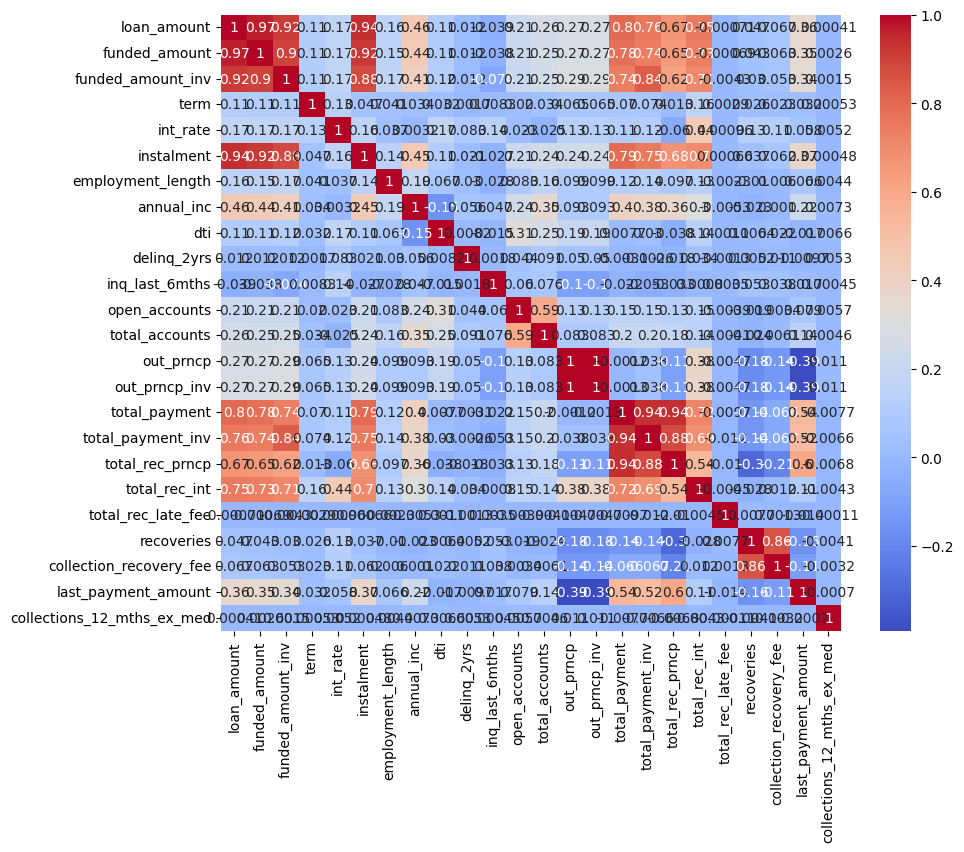

Highly correlated columns: {}
Columns to remove: set()
Dataset after removing highly correlated columns:
   loan_amount  funded_amount  funded_amount_inv  term  int_rate  instalment  \
0           19             19                 19     4      7.49           8   
1           21             21                 21     4      6.99           9   
2           21             21                 21     4      7.49          10   
3           21             21                 21     4     14.31          10   
4           21             21                 21     4      6.03          10   

  grade  employment_length home_ownership  annual_inc  ... total_rec_prncp  \
0     A                  5       MORTGAGE          26  ...              14   
1     A                  9           RENT          27  ...              16   
2     A                  8       MORTGAGE          29  ...              21   
3     C                  0           RENT          26  ...              21   
4     A                 

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset

df = pd.read_csv('/content/transformed_df.csv')

# Step 1: Compute the correlation matrix
corr_matrix = df.corr()

# Visualise the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Step 2: Identify highly correlated columns
# Let's choose 0.75 as the correlation threshold
correlation_threshold = 1.00 # I chose 1 for this but you can move it up or down
highly_correlated = {}

for column in corr_matrix.columns:
    for index in corr_matrix.index:
        if abs(corr_matrix.loc[index, column]) > correlation_threshold and index != column:
            highly_correlated[(index, column)] = corr_matrix.loc[index, column]

print("Highly correlated columns:", highly_correlated)

# Step 3: Decide which columns to remove
# We'll remove the second column in each pair
columns_to_remove = set(column[0] for column in highly_correlated.keys())

print("Columns to remove:", columns_to_remove)

# Step 4: Remove the highly correlated columns from the dataset
df = df.drop(columns=columns_to_remove)

print("Dataset after removing highly correlated columns:")
print(df.head(5))

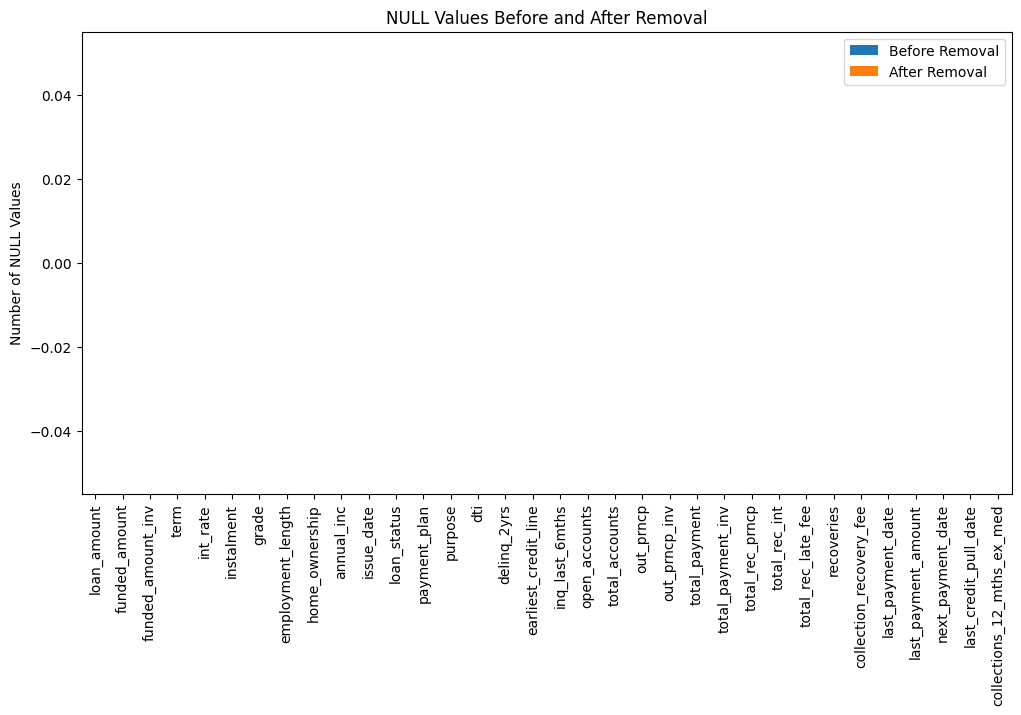

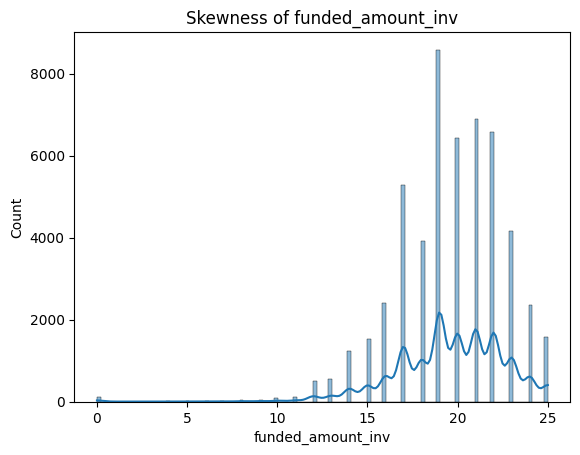

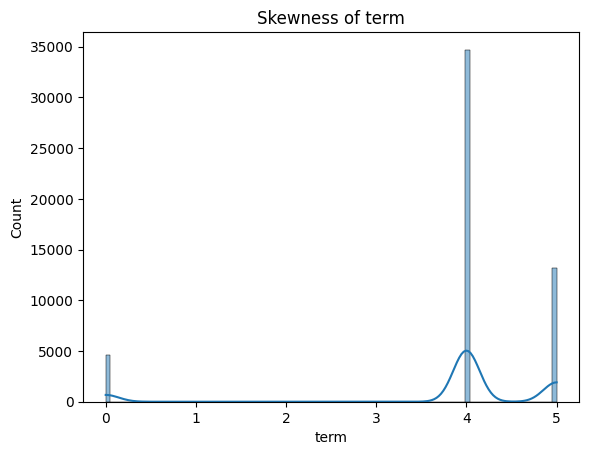

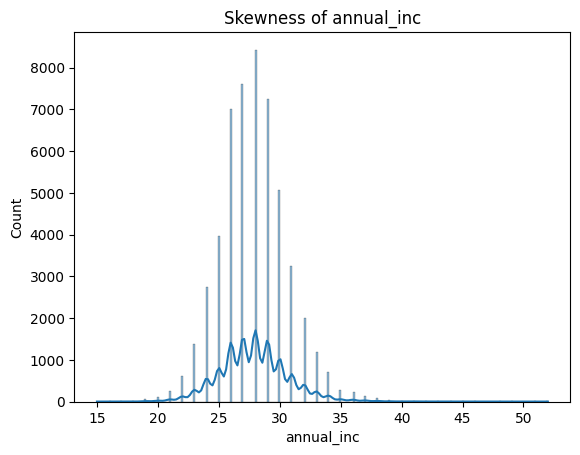

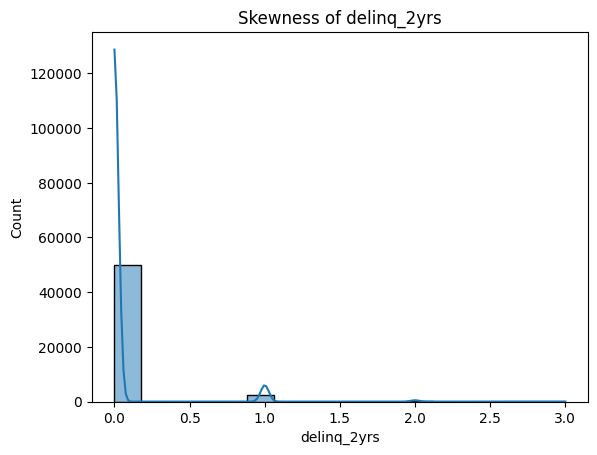

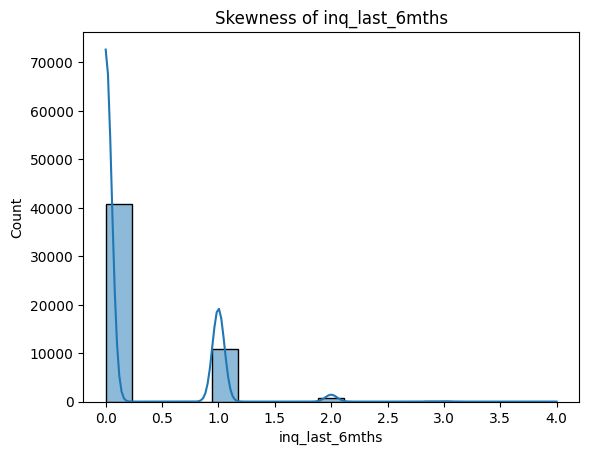

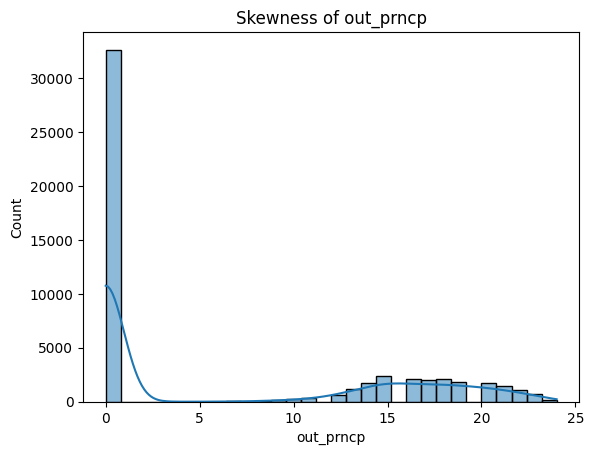

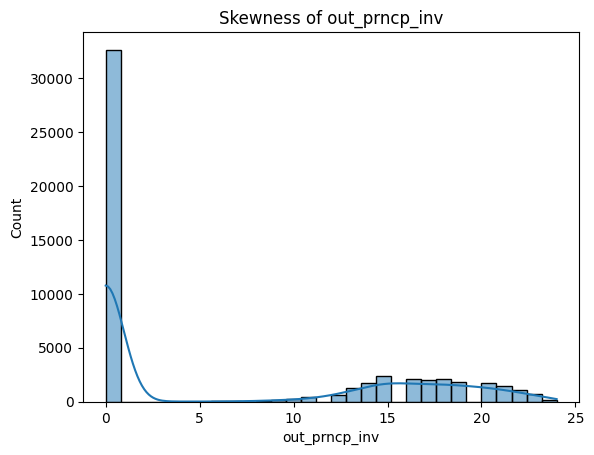

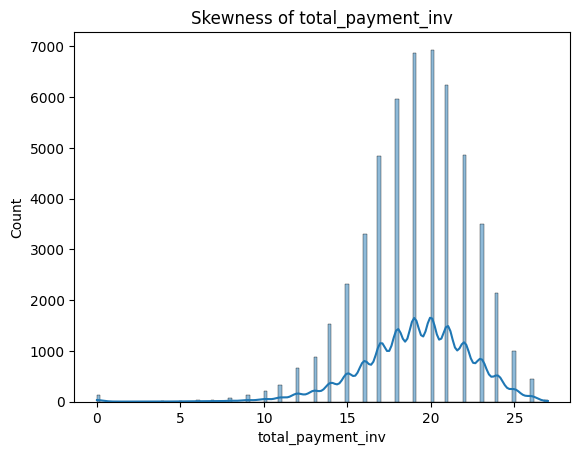

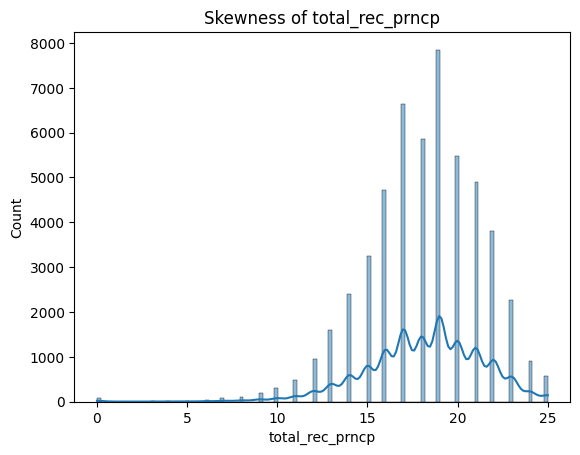

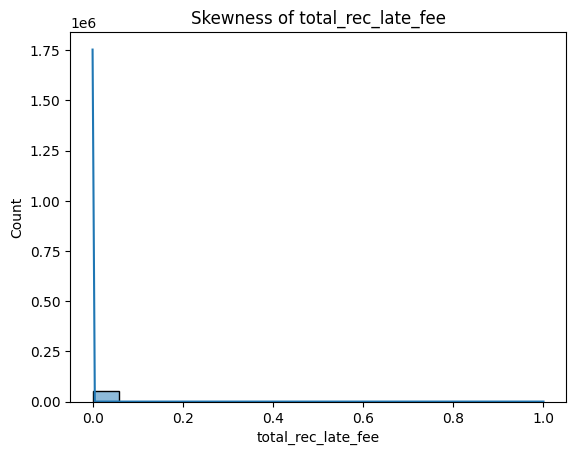

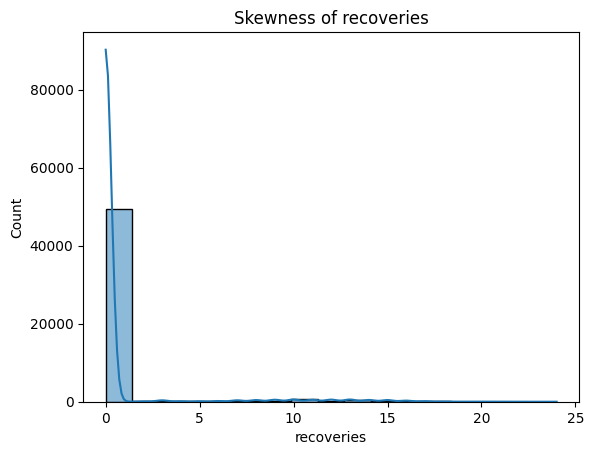

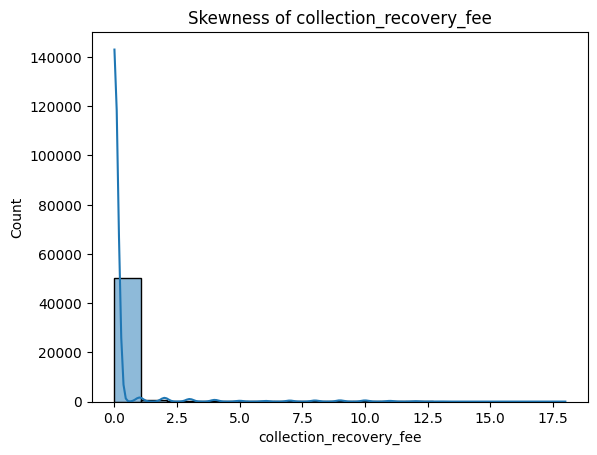

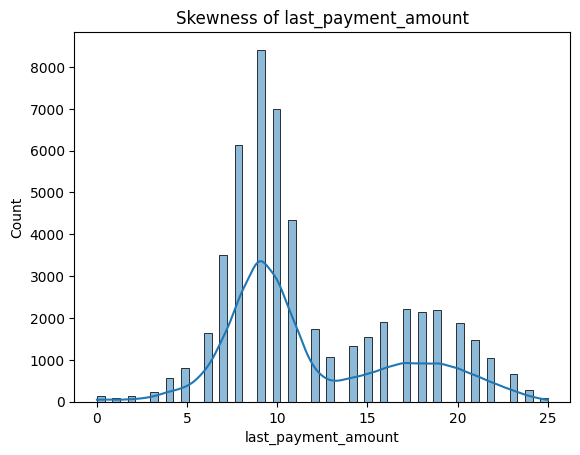

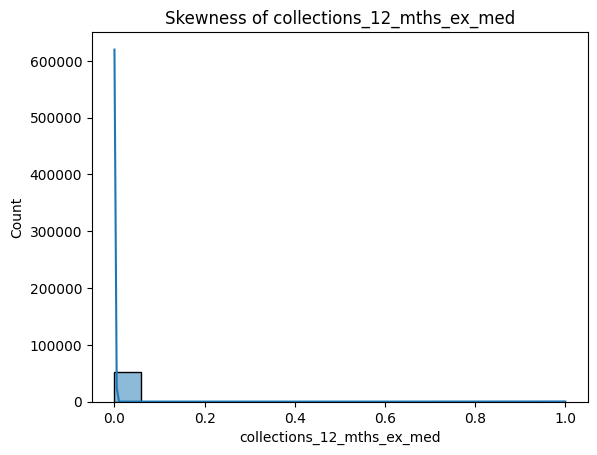

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

class Plotter:
    """
    A class used to plot various aspects of a DataFrame.

    ...

    Attributes
    ----------
    df : DataFrame
        a pandas DataFrame containing the data to be plotted

    Methods
    -------
    plot_null_removal():
        Plots the number of NULL values in each column before and after removal.
    plot_skewness(skew_threshold=0.50):
        Plots the distribution of each column with skewness greater than a specified threshold.
    """

    def __init__(self, df):
        """
        Constructs all the necessary attributes for the Plotter object.

        Parameters
        ----------
            df : DataFrame
                a pandas DataFrame containing the data to be plotted
        """

        self.df = df

    def plot_null_removal(self):
        """
        Plots the number of NULL values in each column before and after removal.
        """

        # Count the number of NULL values in each column before removal
        before_removal = self.df.isnull().sum()

        # Remove NULL values
        df_removed = self.df.dropna()

        # Count the number of NULL values in each column after removal
        after_removal = df_removed.isnull().sum()

        # Create a DataFrame from the before and after Series
        df_plot = pd.DataFrame({'Before Removal': before_removal, 'After Removal': after_removal})

        # Create the plot
        df_plot.plot(kind='bar', figsize=(12, 6))
        plt.title('NULL Values Before and After Removal')
        plt.ylabel('Number of NULL Values')
        plt.show()

    def plot_skewness(self, skew_threshold=0.50):
        """
        Plots the distribution of each column with skewness greater than a specified threshold.

        Parameters
        ----------
        skew_threshold : float, optional
            the skewness threshold for plotting (default is 0.50)
        """

        # Calculate skewness
        skewness = self.df.skew(axis = 0, skipna = True, numeric_only=True)

        # Identify skewed columns
        skewed_cols = skewness[skewness.abs() > skew_threshold].index

        # Plot each skewed column
        for col in skewed_cols:
            sns.histplot(self.df[col], kde=True)
            plt.title(f'Skewness of {col}')
            plt.show()

# Load your data into a DataFrame
df = pd.read_csv(r'/content/transformed_df.csv')

# Create an instance of the Plotter class
plotter = Plotter(df)
plotter.plot_null_removal()
# Plot skewness
plotter.plot_skewness(skew_threshold=0.50)


In [ ]:
import pandas as pd
import numpy as np

class DataFrameInfo:
    """
    A class used to extract information from a DataFrame.

    ...

    Attributes
    ----------
    df : pandas.DataFrame
        a pandas DataFrame containing the data

    Methods
    -------
    describe_all()
        Describes all columns in the DataFrame.
    get_median()
        Returns the median of the DataFrame.
    get_std_dev()
        Returns the standard deviation of the DataFrame.
    get_mean()
        Returns the mean of the DataFrame.
    count_distinct()
        Returns the count of distinct values in each column.
    print_shape()
        Prints the shape of the DataFrame.
    count_nulls()
        Returns the count of NULL values in each column.
    percent_nulls()
        Returns the percentage of NULL values in each column.
    """

    def __init__(self, df):
        """
        Constructs all the necessary attributes for the DataFrameInfo object.

        Parameters
        ----------
            df : pandas.DataFrame
                a pandas DataFrame containing the data
        """

        self.df = df

    def describe_all(self):
     """Describes all columns in the DataFrame."""
     if isinstance(self.df, pd.DataFrame):
        return self.df.describe(include='all', datetime_is_numeric=True)
     else:
        return "The 'df' attribute must be a pandas DataFrame."

    def get_median(self):
        """Returns the median of the DataFrame."""
        return self.df.median(numeric_only=True)

    def get_std_dev(self):
        """Returns the standard deviation of the DataFrame."""
        return self.df.std(numeric_only=True)

    def get_mean(self):
        """Returns the mean of the DataFrame."""
        return self.df.mean(numeric_only=True)

    def count_distinct(self):
        """Returns the count of distinct values in each column."""
        return self.df.nunique()

    def print_shape(self):
        """Prints the shape of the DataFrame."""
        print(f'The DataFrame has {self.df.shape[0]} rows and {self.df.shape[1]} columns.')

    def count_nulls(self):
        """Returns the count of NULL values in each column."""
        return self.df.isnull().sum()

    def percent_nulls(self):
        """Returns the percentage of NULL values in each column."""
        return self.df.isnull().mean() * 100

# Load your data into a DataFrame.
df = pd.read_csv('/content/transformed_df.csv')

# Create an instance of DataFrameInfo
df_info = DataFrameInfo(df)

# Extract data from transormed_df

# To get a description of all columns in the DataFrame
print("Description of all columns in the DataFrame:")
print(df_info.describe_all())

# To get the median of the DataFrame
print("\nMedian of the DataFrame:")
print(df_info.get_median())

# To get the standard deviation of the DataFrame
print("\nStandard deviation of the DataFrame:")
print(df_info.get_std_dev())

# To get the mean of the DataFrame
print("\nMean of the DataFrame:")
print(df_info.get_mean())

# To get the count of distinct values in each column
print("\nCount of distinct values in each column:")
print(df_info.count_distinct())

# To print the shape of the DataFrame
print("\nShape of the DataFrame:")
df_info.print_shape()

# To get the count of NULL values in each column
print("\nCount of NULL values in each column:")
print(df_info.count_nulls())

# To get the percentage of NULL values in each column
print("\nPercentage of NULL values in each column:")
print(df_info.percent_nulls())


Description of all columns in the DataFrame:
         loan_amount  funded_amount  funded_amount_inv          term  \
count   52477.000000   52477.000000       52477.000000  52477.000000   
unique           NaN            NaN                NaN           NaN   
top              NaN            NaN                NaN           NaN   
freq             NaN            NaN                NaN           NaN   
mean       19.810584      19.796215          19.610134      3.898508   
std         2.718664       2.633365           2.999164      1.284138   
min        10.000000      10.000000           0.000000      0.000000   
25%        18.000000      18.000000          18.000000      4.000000   
50%        20.000000      20.000000          20.000000      4.000000   
75%        22.000000      22.000000          22.000000      5.000000   
max        25.000000      25.000000          25.000000      5.000000   

            int_rate    instalment  grade  employment_length home_ownership  \
count   524

In [ ]:
import datetime as dt
import os
import pandas as pd


def read_csv_file():
    data_set = pd.read_csv('transformed_df.csv')
    return (data_set)

df = read_csv_file()
df

,loan_amount,funded_amount,funded_amount_inv,term,int_rate,instalment,grade,employment_length,home_ownership,annual_inc,...,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med
0,19,19,19,4,7.49,8,A,5,MORTGAGE,26,...,14,10,0,0,0,2022-01-01,8,2022-02-01,2022-01-01,0
1,21,21,21,4,6.99,9,A,9,RENT,27,...,16,11,0,0,0,2022-01-01,9,2022-02-01,2022-01-01,0
2,21,21,21,4,7.49,10,A,8,MORTGAGE,29,...,21,11,0,0,0,2021-10-01,20,2021-11-01,2021-10-01,0
3,21,21,21,4,14.31,10,C,0,RENT,26,...,21,11,0,0,0,2021-06-01,21,2021-07-01,2021-06-01,0
4,21,21,21,4,6.03,10,A,10,MORTGAGE,32,...,17,11,0,0,0,2022-01-01,10,2022-02-01,2022-01-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52472,20,20,12,0,15.01,9,F,0,RENT,22,...,20,13,0,0,0,2014-07-01,19,2014-08-01,2013-06-01,0
52473,17,17,13,4,9.01,7,B,0,MORTGAGE,36,...,17,11,0,0,0,2016-07-01,7,2016-08-01,2016-07-01,0
52474,16,16,14,4,7.43,6,A,10,MORTGAGE,37,...,16,9,0,0,0,2016-09-01,6,2016-10-01,2013-05-01,0
52475,17,17,8,4,7.43,7,A,4,RENT,34,...,17,7,0,0,0,2014-03-01,0,2014-04-01,2013-05-01,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52477 entries, 0 to 52476
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amount                 52477 non-null  int64  
 1   funded_amount               52477 non-null  int64  
 2   funded_amount_inv           52477 non-null  int64  
 3   term                        52477 non-null  int64  
 4   int_rate                    52477 non-null  float64
 5   instalment                  52477 non-null  int64  
 6   grade                       52477 non-null  object 
 7   employment_length           52477 non-null  int64  
 8   home_ownership              52477 non-null  object 
 9   annual_inc                  52477 non-null  int64  
 10  issue_date                  52477 non-null  object 
 11  loan_status                 52477 non-null  object 
 12  payment_plan                52477 non-null  object 
 13  purpose                     524

In [ ]:
data = df.mean()
data_1 = df.median()

print("Mean:\n", round(data))
print("Median:\n", data_1)

Mean:
 loan_amount                   20.0
funded_amount                 20.0
funded_amount_inv             20.0
term                           4.0
int_rate                      13.0
instalment                     9.0
employment_length              5.0
annual_inc                    28.0
dti                           16.0
delinq_2yrs                    0.0
inq_last_6mths                 0.0
open_accounts                  2.0
total_accounts                 4.0
out_prncp                      6.0
out_prncp_inv                  6.0
total_payment                 19.0
total_payment_inv             19.0
total_rec_prncp               18.0
total_rec_int                 13.0
total_rec_late_fee             0.0
recoveries                     1.0
collection_recovery_fee        0.0
last_payment_amount           12.0
collections_12_mths_ex_med     0.0
dtype: float64
Median:
 loan_amount                   20.00
funded_amount                 20.00
funded_amount_inv             20.00
term                 

<ipython-input-90-1b3594a96619>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data = df.mean()
<ipython-input-90-1b3594a96619>:2: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_1 = df.median()


Average recovery percentage against investor funding: 31.632105852401327
Average recovery percentage against total funded: 31.598636188554728
-12.0
       loan_amount  funded_amount  funded_amount_inv  term  int_rate  \
3               21             21                 21     4     14.31   
4               21             21                 21     4      6.03   
5               14             14                 14     4     11.44   
7               24             24                 23     0     19.99   
8               19             19                 19     5     12.99   
...            ...            ...                ...   ...       ...   
52461           12             12                 10     4     10.28   
52471           16             16                 13     4      9.64   
52473           17             17                 13     4      9.01   
52474           16             16                 14     4      7.43   
52476           17             17                  9     4  

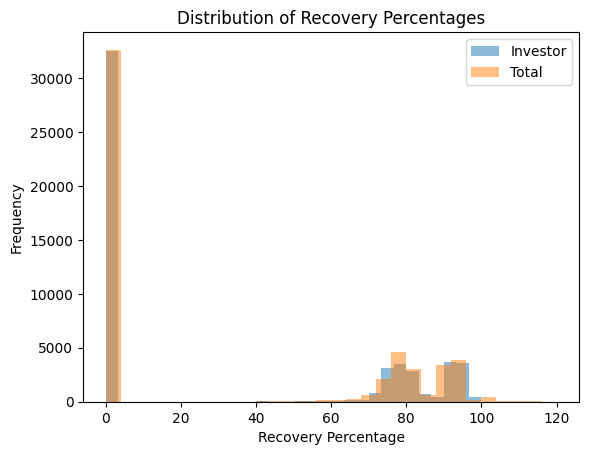

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r'/content/transformed_df.csv')

# Based on
df['recovery_percentage_investor'] = df['out_prncp_inv'] / df['funded_amount_inv'] * 100
df['recovery_percentage_total'] = df['out_prncp'] / df['funded_amount'] * 100

# Print the average recovery percentages
print("Average recovery percentage against investor funding:", df['recovery_percentage_investor'].mean())
print("Average recovery percentage against total funded:", df['recovery_percentage_total'].mean())


# Calculate the remaining balance of the loan
df['remaining_balance'] = df['loan_amount'] - df['total_payment']

average_recovery_per_month = df['total_payment'].diff()
df['amount_to_be_recovered_in_6_months'] = average_recovery_per_month * 6

print(df['amount_to_be_recovered_in_6_months'].sum())

negative_recoveries = df[df['amount_to_be_recovered_in_6_months'] < 0]
print(negative_recoveries)

plt.hist(df['recovery_percentage_investor'], bins=30, alpha=0.5, label='Investor')
plt.hist(df['recovery_percentage_total'], bins=30, alpha=0.5, label='Total')
plt.legend(loc='upper right')
plt.title('Distribution of Recovery Percentages')
plt.xlabel('Recovery Percentage')
plt.ylabel('Frequency')
plt.show()


In [ ]:
import pandas as pd

df = pd.read_csv(r'/content/transformed_df.csv')

charged_off_loans = df[df['loan_status'] == 'Charged Off']

# Calculate the percentage of charged off loans
percentage_charged_off = round(len(charged_off_loans) / len(df) * 100)
print(f"Percentage of charged off loans: {percentage_charged_off}%")


# Create a mask for payments made before the last payment date
mask = df['issue_date'] < df['last_payment_date']

# Calculate the total payment made before the last payment date
total_payment_previous = round(df.loc[mask, 'total_payment'].sum())

print(f'Total payment made before the last payment date: {total_payment_previous}')

Percentage of charged off loans: 9%
Total payment made before the last payment date: 1011561


In [ ]:
charged_off_loans = df[df['loan_status'] == 'Charged Off']


# Calculate the total projected loss for charged off loans
total_projected_loss = round((charged_off_loans['loan_amount'] - charged_off_loans['total_payment']).sum())
print(f"Total projected loss of the loans marked as 'Charged Off': {total_projected_loss}")

# Calculate the total loss in revenue these loans would have generated for the company if they had finished their term
total_revenue_loss = round(((charged_off_loans['loan_amount'] * (1 + charged_off_loans['int_rate'] / 100) ** charged_off_loans['term']) - charged_off_loans['total_payment']).sum())
print(f"Total loss in revenue these loans would have generated for the company if they had finished their term: {total_revenue_loss}")

# Calculate the total loan amount for charged off loans
total_loan_amount = charged_off_loans['loan_amount'].sum()

# Calculate the percentage of the total projected loss
percentage_projected_loss = round((total_projected_loss / total_loan_amount) * 100)
print(f"Percentage of the total projected loss of the loans marked as 'Charged Off': {percentage_projected_loss}%")

# Calculate the percentage of the total loss in revenue
percentage_revenue_loss = round((total_revenue_loss / total_loan_amount) * 100)
print(f"Percentage of the total loss in revenue these loans would have generated for the company if they had finished their term: {percentage_revenue_loss}%")


Total projected loss of the loans marked as 'Charged Off': 16437
Total loss in revenue these loans would have generated for the company if they had finished their term: 99192
Percentage of the total projected loss of the loans marked as 'Charged Off': 17%
Percentage of the total loss in revenue these loans would have generated for the company if they had finished their term: 100%


In [ ]:
import pandas as pd

# Load your data into a DataFrame
df = pd.read_csv(r'/content/transformed_df.csv')

# Filter the DataFrame to include only defaulted loans
defaulted_loans = df[df['loan_status'].isin(['Default','Late (31-120 days)','Late (16-30 days)'])]

# Calculate the percentage of defaulted loans
percentage_defaulted = (len(defaulted_loans) / len(df)) * 100
print(f"Percentage of defaulted loans: {percentage_defaulted}%")

# Calculate the total loan amount for defaulted loans
total_defaulted_loan_amount = defaulted_loans['loan_amount'].sum()
print(f"Total loan amount of defaulted loans: {total_defaulted_loan_amount}")

Percentage of defaulted loans: 1.187186767536254%
Total loan amount of defaulted loans: 12641


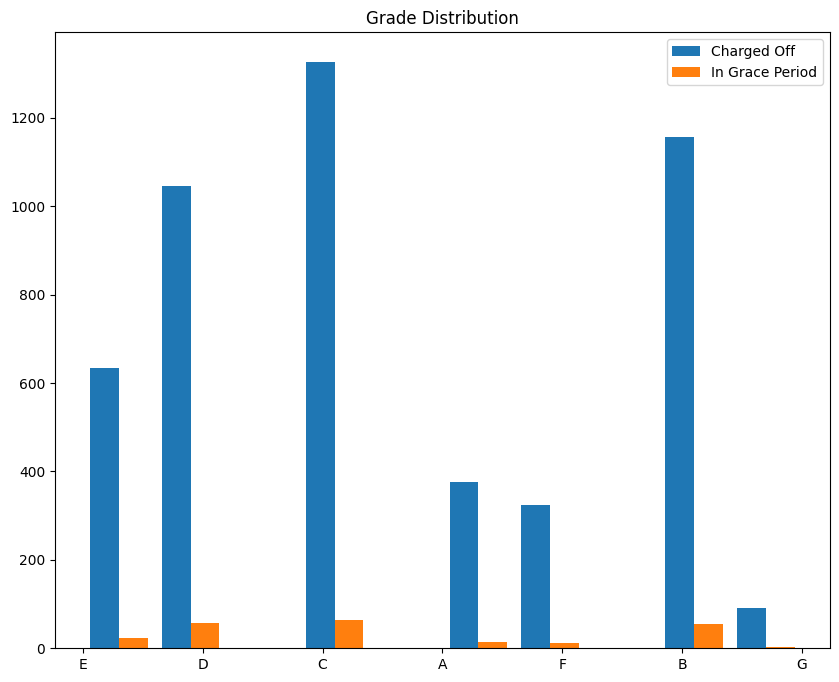

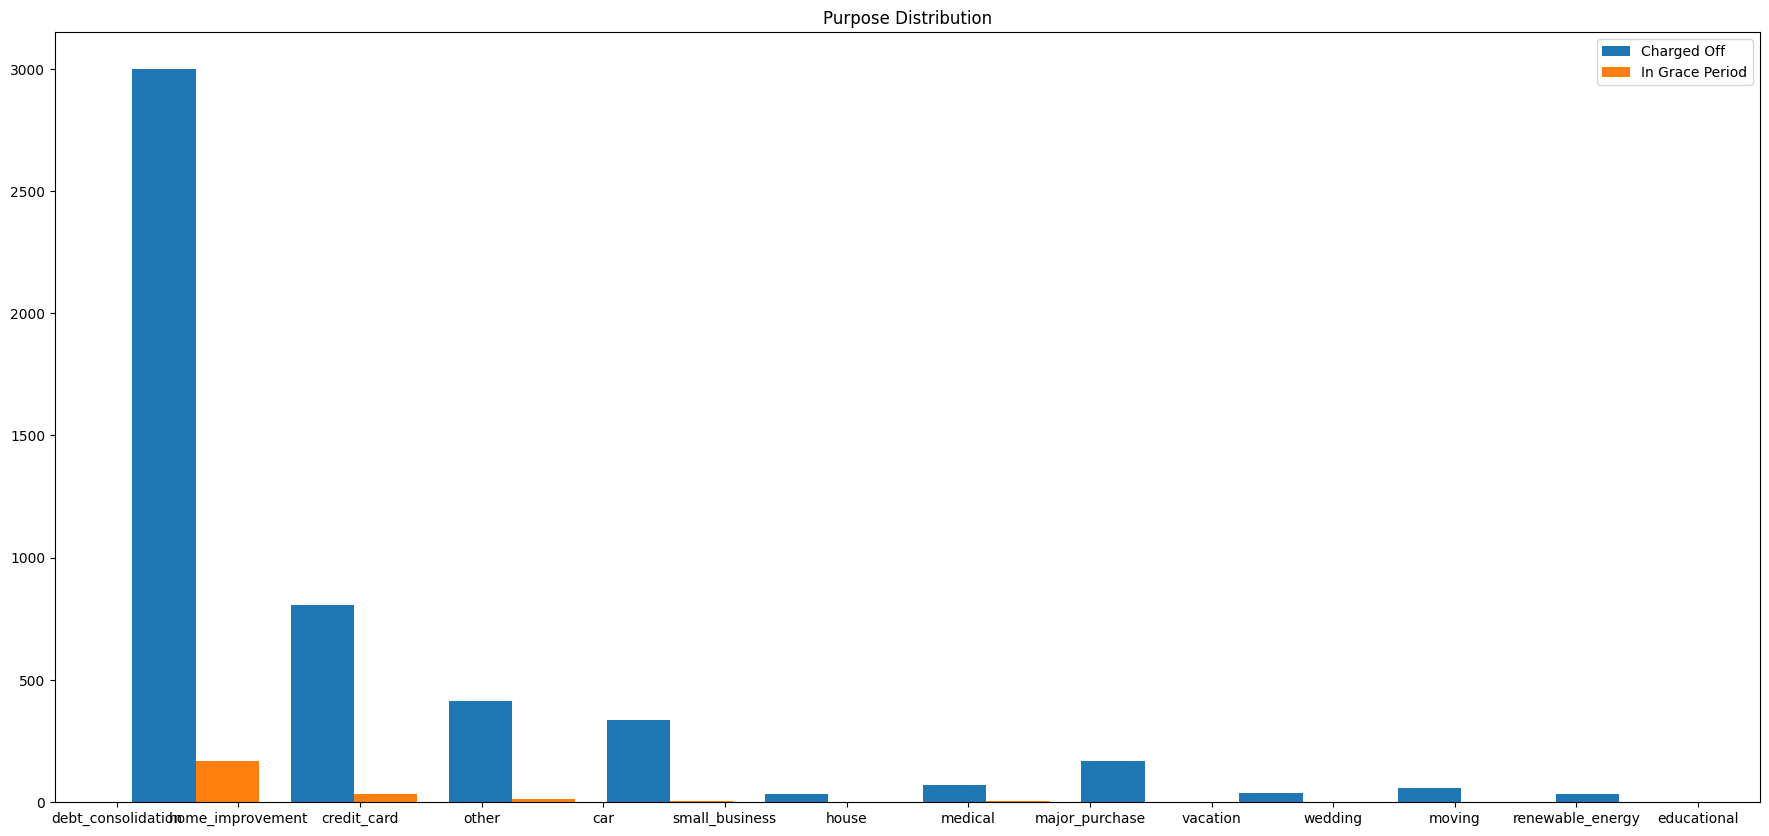

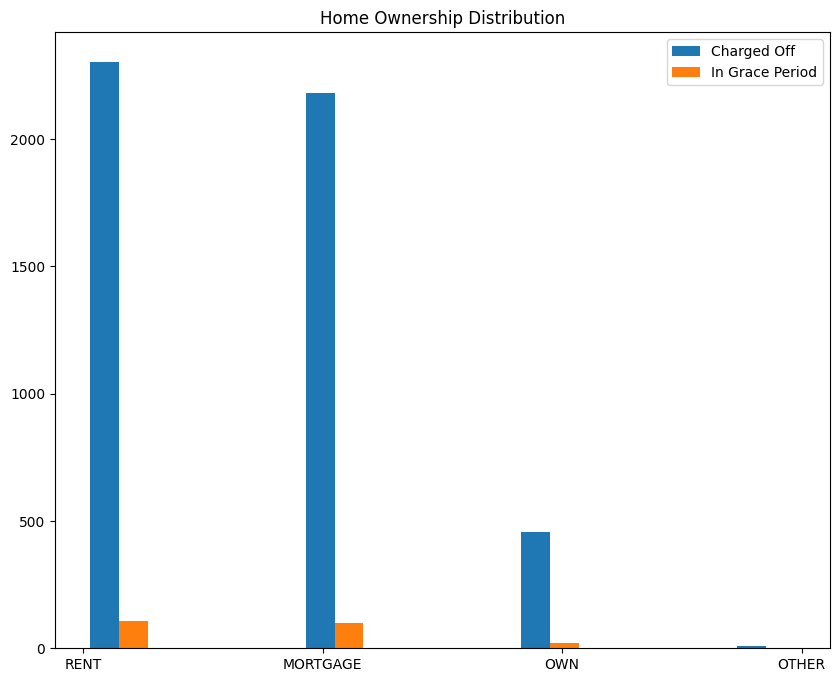

In [ ]:
charged_off_loans = df[df['loan_status'] == 'Charged Off']
behind_loans = df[df['loan_status'] == 'In Grace Period']

import matplotlib.pyplot as plt

# Compare the grade distributions
plt.figure(figsize=(10, 8))
plt.hist([charged_off_loans['grade'], behind_loans['grade']], label=['Charged Off', 'In Grace Period'])
plt.legend(loc='upper right')
plt.title('Grade Distribution')
plt.show()

# Compare the purpose distributions
plt.figure(figsize=(22,10))
plt.hist([charged_off_loans['purpose'], behind_loans['purpose']], label=['Charged Off', 'In Grace Period'])
plt.legend(loc='upper right')
plt.title('Purpose Distribution')
plt.show()

# Compare the home_ownership distributions
plt.figure(figsize=(10, 8))
plt.hist([charged_off_loans['home_ownership'], behind_loans['home_ownership']], label=['Charged Off', 'In Grace Period'])
plt.legend(loc='upper right')
plt.title('Home Ownership Distribution')
plt.show()
